In [8]:
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.regularizers as reg
import keras_tuner as kt
import importlib

import kaggle_functions as kaggle
importlib.reload(kaggle); 

model_number = 'autoencoder'

In [2]:
train_datasets, valid_datasets = kaggle.load_train_as_dataset_autoencoder()

In [39]:
class AutoEncoder(kt.HyperModel):
    def autoencoder_layer(
        self, input, filters, stride=2, l2_reg=0, dropout=0, 
        decoding=False, activation=True, padding='same'):

        # Encoding and decoding layers must be very similar
        if not decoding:
            conv = layers.Conv2D(
                filters, kernel_size=(3,3), strides=(stride,stride), padding=padding,
                kernel_regularizer=reg.l2(l2_reg), bias_regularizer=reg.l2(l2_reg),
                kernel_initializer='he_uniform')(input)
        else:
            conv = layers.Conv2DTranspose(
                filters, kernel_size=(3,3), strides=(stride,stride), padding=padding,
                kernel_regularizer=reg.l2(l2_reg), bias_regularizer=reg.l2(l2_reg),
                kernel_initializer='he_uniform')(input)

        # Directly returns on final layer (final capped activation)
        if activation:
            return layers.ReLU(max_value=1, negative_slope=0)(conv)

        bn = layers.BatchNormalization()(conv)
        relu = layers.ReLU()(bn)

        if dropout != 0:
            return layers.SpatialDropout2D(dropout)(relu)

        return relu

    def build(self, hyperparameters):
        # Tunable hyperparameters
        if hyperparameters is not None:
            dropout = hyperparameters.Float('dropout', 0.05, 0.2, step=0.05)
            l2_reg = hyperparameters.Choice('l2_reg', [0.00001, 0.0001, 0.001])

        else:
            dropout = 0
            l2_reg = 0

        # Fixed hyperparameters
        learning_rate = 0.0001

        # Input images
        input_layer = layers.Input(shape=(96, 96, 1))

        # Encoder
        output = self.autoencoder_layer(input_layer, 32, l2_reg=l2_reg)
        output = self.autoencoder_layer(output, 64, l2_reg=l2_reg)
        output = self.autoencoder_layer(output, 128, l2_reg=l2_reg)
        output = self.autoencoder_layer(output, 256, l2_reg=l2_reg)
        output = self.autoencoder_layer(output, 512, l2_reg=l2_reg)
        output = self.autoencoder_layer(output, 1024, stride=1, padding='valid', l2_reg=l2_reg)
        # Decoder
        output = self.autoencoder_layer(output, 512, stride=1, padding='valid', l2_reg=l2_reg, decoding=True)
        output = self.autoencoder_layer(output, 256, l2_reg=l2_reg, decoding=True)
        output = self.autoencoder_layer(output, 128, l2_reg=l2_reg, decoding=True)
        output = self.autoencoder_layer(output, 64, l2_reg=l2_reg, decoding=True)
        output = self.autoencoder_layer(output, 32, l2_reg=l2_reg, decoding=True)
        output = self.autoencoder_layer(output, 1, l2_reg=l2_reg, decoding=True, activation=True)

        model = keras.models.Model(inputs=input_layer, outputs=output, name='stacked_model')

        # Create model
        model.compile(
            optimizer=keras.optimizers.Nadam(learning_rate),
            loss=keras.losses.MeanSquaredError())

        return model

In [40]:
AutoEncoder().build(None).summary()

Model: "stacked_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 96, 96, 1)]       0         
                                                                 
 conv2d_55 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 re_lu_99 (ReLU)             (None, 48, 48, 32)        0         
                                                                 
 conv2d_56 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 re_lu_100 (ReLU)            (None, 24, 24, 64)        0         
                                                                 
 conv2d_57 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 re_lu_101 (ReLU)            (None, 12, 12, 128)     

In [26]:
animal_models = []
for i in range(1):
    model, history = kaggle.train_model(
        AutoEncoder().build(None), 
        train_datasets[i], valid_datasets[i],
        epochs=200, valid_patience=10, patience_metric='val_loss')
    animal_models.append(model)

Epoch 1/200
31/31 - 6s - loss: 0.1047 - val_loss: 0.0691 - lr: 1.0000e-04 - 6s/epoch - 198ms/step
Epoch 2/200
31/31 - 3s - loss: 0.0572 - val_loss: 0.0464 - lr: 1.0000e-04 - 3s/epoch - 97ms/step
Epoch 3/200
31/31 - 3s - loss: 0.0431 - val_loss: 0.0381 - lr: 1.0000e-04 - 3s/epoch - 97ms/step
Epoch 4/200
31/31 - 3s - loss: 0.0375 - val_loss: 0.0343 - lr: 1.0000e-04 - 3s/epoch - 97ms/step
Epoch 5/200
31/31 - 3s - loss: 0.0341 - val_loss: 0.0316 - lr: 1.0000e-04 - 3s/epoch - 96ms/step
Epoch 6/200
31/31 - 3s - loss: 0.0315 - val_loss: 0.0292 - lr: 1.0000e-04 - 3s/epoch - 95ms/step
Epoch 7/200
31/31 - 3s - loss: 0.0296 - val_loss: 0.0277 - lr: 1.0000e-04 - 3s/epoch - 96ms/step
Epoch 8/200
31/31 - 3s - loss: 0.0274 - val_loss: 0.0263 - lr: 1.0000e-04 - 3s/epoch - 95ms/step
Epoch 9/200
31/31 - 3s - loss: 0.0255 - val_loss: 0.0241 - lr: 1.0000e-04 - 3s/epoch - 96ms/step
Epoch 10/200
31/31 - 3s - loss: 0.0246 - val_loss: 0.0243 - lr: 1.0000e-04 - 3s/epoch - 95ms/step
Epoch 11/200
31/31 - 3s - lo

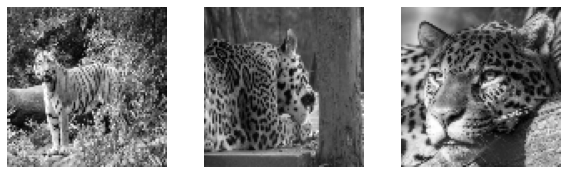

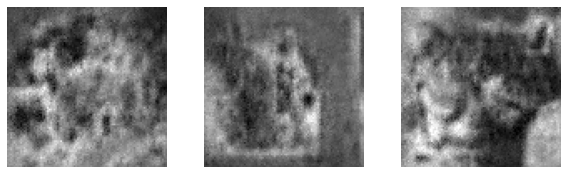

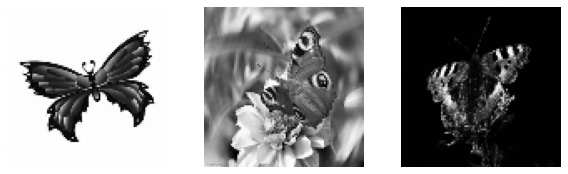

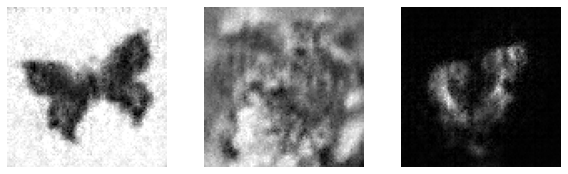

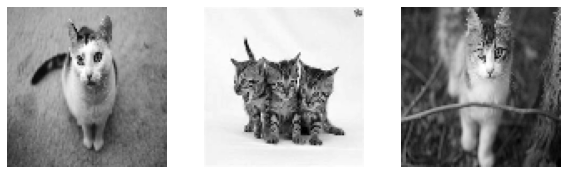

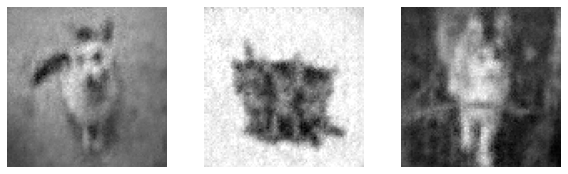

In [43]:
for i in range(8):
    kaggle.show_images_autoencoder(animal_models[0], train_datasets[i], 3)